# Method: LSTM
# Dataset: Lorenz-96, F = 8
# Purpose: Uncertainty Quantification - Deep Ensemble

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time
from functools import partial

import jax
import jax.numpy as jnp
from jax.nn.initializers import glorot_normal, normal
from jax.example_libraries import optimizers

In [3]:
train, test = load_data("Lorenz 96, F = 8", "../../data/lorenz8", 0.5)

In [4]:
np.random.seed(1)
train.data = train.data + np.random.normal(0, 1e-1, train.data.shape)

In [5]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (90000, 40)
Test size: (90000, 40)


**Create test set**

In [6]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [7]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 200 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [8]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 40)
Test output size: (100, 400, 40)


# 2. LSTM Implementation

In [16]:
def LSTM(h_dim, data_dim, W_init = glorot_normal(), b_init = normal()):
    """
    args:
    ====
     h_dim: dimension of the internal state
     data_dim: dimensionity of the time series

    outputs:
    ======
     init_fun: function to initialize the parameters
     process: function to process a time-series and compute the final prediction and final internal state
     forecast: function that, given a pair (internal-state, input), computes the next T predictions
    """
    
    def init_fun(rng):
        """
        This function initialize the weights of the RNN
        
        args:
        ====
         rng: jax RNG
         
        outputs:
        ======
         params: a tuple of parameters
        """
        
        # Forget Layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        fU = W_init(k1, (h_dim, data_dim))
        fW = W_init(k2, (h_dim, h_dim)) 
        fb = b_init(k3, (h_dim,))
        
        # Input Layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        iU = W_init(k1, (h_dim, data_dim))
        iW = W_init(k2, (h_dim, h_dim))
        ib = b_init(k3, (h_dim,))
        
        # Candidate layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        gU = W_init(k1, (h_dim, data_dim))
        gW = W_init(k2, (h_dim, h_dim))
        gb = b_init(k3, (h_dim,))
        
        # Output layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        oU = W_init(k1, (h_dim, data_dim))
        oW = W_init(k2, (h_dim, h_dim))
        ob = b_init(k3, (h_dim,))
        
        # Dense layer (hidden -> y)
        k1, k2 = jax.random.split(rng, num = 2)
        dO = W_init(k1, (data_dim, h_dim))
        db = b_init(k2, (data_dim,))
                
        params = fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db
        return params
    
    def process(params, time_series):
        """
        This function takes a time-series in input, pass it through the RNN, 
        and finally outputs the last prediction and internal state
        
        args:
        ====
         params: tuple of parameters
         time_series: data of dimension (T, dim_data)
         
        outputs:
        =======
         c_final: jax vector of dimension nn_size
         h_final: jax vector of dimension nn_size
         pred_traj[-1]: last prediction
        """
        
        fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db = params 
        
        c_zero = np.zeros((h_dim, ))
        h_zero = np.zeros((h_dim, ))
        
        # forward pass
        def process_internal(start, x):
            c, h = start
            
            forget_gate = sigmoid(jnp.dot(fU, x) + jnp.dot(fW, h) + fb)
            input_gate = sigmoid(jnp.dot(iU, x) + jnp.dot(iW, h) + ib)
            cand_gate = jnp.tanh(jnp.dot(gU, x) + jnp.dot(gW, h) + gb)
            c_new = sigmoid(forget_gate * c + input_gate * cand_gate)    
            output_gate = sigmoid(jnp.dot(oU, x) + jnp.dot(oW, h) + ob)
            h_new = jnp.tanh(c_new) * output_gate
            y = x + dO @ h_new + db
            
            return (c_new, h_new), y
        (c_final, h_final), pred_traj = jax.lax.scan(process_internal, (c_zero, h_zero), time_series)
        return (c_final, h_final), pred_traj[-1]
    
    
    def forecast(params, internal_states, x_input, horizon):
        """
        This function takes in an internal state and a first input and produces 
        prediction over a finite horizon.
        
        args:
        ====
         params: tuple of parameters
         internal_states = (c_internal, h_internal): internal state values of c and h
         x_input: jax vector of dimension dim_data
         horizon: horizon of the prediction
         
        outputs:
        =======
         preds: a trajectory of prediction of dimension (horison, dim_data) 
        """
        c_internal, h_internal = internal_states
        # extract parameters
        fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db = params 
        
        # forward pass
        def forecast_internal(triple_c_h_x, _ ):
            cell, hidden, x = triple_c_h_x
            
            forget_gate = sigmoid(jnp.dot(fU, x) + jnp.dot(fW, hidden) + fb)
            input_gate = sigmoid(jnp.dot(iU, x) + jnp.dot(iW, hidden) + ib)
            cand_gate = jnp.tanh(jnp.dot(gU, x) + jnp.dot(gW, hidden) + gb)
            c_new = sigmoid(forget_gate * cell + input_gate * cand_gate)    
            output_gate = sigmoid(jnp.dot(oU, x) + jnp.dot(oW, hidden) + ob)
            h_new = jnp.tanh(c_new) * output_gate
            y = x + dO @ h_new + db
            
            return (c_new, h_new, y), y
        
        _, pred_traj = jax.lax.scan(forecast_internal, (c_internal, h_internal, x_input), None, length=horizon)
        
        # return the trajectory of predictions
        return pred_traj
    
    return init_fun, process, forecast

In [17]:
def get_parameters(nn_size, seed, batch_size, L_past, L_forecast_train, 
                   num_epoch, lr_schedule, early_stopping = EARLY_STOPPING, 
                  early_stopping_baseline = 1.1):
    assert len(num_epoch) == len(lr_schedule)
    def training(x, y, init_params):
        @jax.jit
        def step(i, opt_state, x_batch, y_batch):
            params = get_params(opt_state)
            value, g = jax.value_and_grad(mse)(params, x_batch, y_batch)
            opt_state = opt_update(i, g, opt_state)
            return get_params(opt_state), opt_state, value
        
        @partial(jax.jit, static_argnums=2)
        def make_forecast(params, x_batch, horizon):
            # pass the data through the RNN. 
            # note that "preds" is the first forecasts
            hs, preds = process_batch(params, x_batch)
            # compute the (L_forecast-1) next forecasts
            y_pred = forecast_batch(params, hs, preds, horizon-1)
            #stick all the forecasts together
            y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

            return y_pred

        @jax.jit
        def mse(params, x_batch, y_truth):
            """
            For each time-series in a batch, forecasts over a finite horizon 
            and compute the MSE.

            args:
            ====
             params: neural parameters
             x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
             y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

            outputs:
            =======
             MSE: MSE between forecasts and targets
            """

            # horizon of the forecast
            L_forecast = y_truth.shape[1]    
            y_pred = make_forecast(params, x_batch, L_forecast)

            #compute MSE
            error = y_pred - y_truth
            mu_loss = jnp.mean(error**2)
            return mu_loss 
        
        start = time()
                
        loss_train_traj = []
        loss_train_all_traj = []
        
        overall_best_params = init_params
        overall_best_mse = 999999999
        
        # train/val split
        t_size = int(0.9 * train_size)
        v_size = train_size - t_size
        T_indices_val = np.arange(t_size, train_size - (L_forecast_test//2 + L_past))
        t_start_val = T_indices_val[::10]
        t_past_batch_val = (t_start_val[:,None] + np.arange(L_past)[None,:]).astype(int) 
        t_pred_batch_val = (t_start_val[:,None] + np.arange(L_past,L_past+L_forecast_test//2)[None,:]).astype(int) 
        x_val = data_test[t_past_batch_val]
        y_val = data_test[t_pred_batch_val]
        
        
        print("Backpropogation start", end = "\n\n")
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init(overall_best_params)
            counter = 0
            best_mse = 999999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                # randomize the order of the training data
                T_indices = np.arange(t_size - (L_forecast_train + L_past))
                np.random.shuffle(T_indices)
                
                # training
                loss_epoch_train = []
                
                for k in range(t_size // batch_size + 1):
                    # create a batch of data
                    t_start = T_indices[np.arange(k*batch_size, (k+1)*batch_size).astype(int) % len(T_indices)] # start of each time series in the batch
                    # create 2d array of dimension (batch_size, L_past) containing all the time indices
                    t_past_batch = (t_start[:,None] + np.arange(L_past)[None,:]).astype(int) # transposes data
                    t_pred_batch = (t_start[:,None] + np.arange(L_past,L_past+L_forecast_train)[None,:]).astype(int) 

                    #create batch of dimension (batch_size, L_past, data_dim)
                    x_batch = x[t_past_batch]  
                    y_batch = y[t_pred_batch]

                    params, opt_state, loss_current = step(k, opt_state, x_batch, y_batch) # update
                    loss_epoch_train.append(loss_current)
                
                mse_train = np.mean(loss_epoch_train)
                
                # validation             
                mse_val = mse(params, x_val, y_val)
                
                if  best_mse > mse_val: # Improvement
                    counter = 0
                    best_mse = mse_val
                    best_params = params
                else:
                    counter += 1
                
                e_end = time()
                if (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch + 1}: Time taken = {e_end - e_start:.2f} | Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                
                if best_mse < early_stopping_baseline and counter >= early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                    break
            print(f"Best Validation MSE: {best_mse:.7f}")
            
            if best_mse < overall_best_mse: # Best round so far
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_mse
                overall_best_params = best_params
            print()
        
        end = time()
        print(f"Total time: {end - start:.2f}")
        
        return overall_best_params

    start = time()
    x, y = train.data[:-1], train.data[1:]
    train_size, data_dim = x.data.shape
    
    np.random.seed(seed)
    key = jax.random.PRNGKey(seed)
    
    # Initialize LSTM
    init_fun, process, forecast = LSTM(nn_size, data_dim)       # LSTM Network
    process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
    forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)
    init_params = init_fun(key)
    
    final_params = training(x, y, init_params)
    end = time()
    print(f"Complete. Time taken: {end - start:.2f}s")
    
    return final_params, (process_batch, forecast_batch)

In [18]:
def get_test_pred(data_test, params, lstm_fx):  
    @partial(jax.jit, static_argnums=2)
    def make_forecast(params, x_batch, horizon):
        pbatch, fbatch = lstm_fx
        # pass the data through the RNN. 
        # note that "preds" is the first forecasts
        hs, preds = pbatch(params, x_batch)
        # compute the (L_forecast-1) next forecasts
        y_pred = fbatch(params, hs, preds, horizon-1)
        #stick all the forecasts together
        y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

        return y_pred

    @jax.jit
    def loss(params, x_batch, y_truth):
        """
        For each time-series in a batch, forecasts over a finite horizon 
        and compute the MSE.

        args:
        ====
         params: neural parameters
         x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
         y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

        outputs:
        =======
         MSE: MSE between forecasts and targets

        """

        # horizon of the forecast
        L_forecast = y_truth.shape[1]    
        y_pred = make_forecast(params, x_batch, L_forecast)

        #compute MSE
        error = y_pred - y_truth
        return jnp.mean(error**2)
    
    start = time()
    num_data_test, L_past, data_dim = data_test.shape # testing ex, # steps used before, dim of data
    mu_pred = make_forecast(params, data_test, L_forecast_test)
    end = time()
    print(f"Testing complete. Time taken: {end - start:.2f}")
    return np.array(mu_pred)

# 3. Best Parameters

In [19]:
nn_size = 500
L_forecast_train = 4
L_past = 4

b_size = 128 # Batch size
lr_list = [1e-3, 1e-4, 1e-5, 1e-6] # Learning rate schedule
epoch_list = [200, 200, 200, 200]  # Number of epochs for each learning rate

# 4. Ensemble

In [20]:
res_folder = os.path.join("results", "ensemble_noise")

In [21]:
def run_seed(seed):
    """
    Runs the experiment with optimal parameters and appends the predictions into the global variable mu_preds
    """
    params, lstm_fx = get_parameters(nn_size = nn_size, seed = seed, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,
                                early_stopping = 50)
    mean_pred = get_test_pred(X_test, params, lstm_fx)
    file_name = "mu_preds_" + str(seed) + ".pkl"
    save_obj(mean_pred, res_folder, file_name)

## 4.1 Seed 2

In [22]:
run_seed(2)

Backpropogation start

Epoch 10: Time taken = 3.18 | Train loss = 0.0210914 | Val loss =  1.4901116
Epoch 20: Time taken = 3.10 | Train loss = 0.0183117 | Val loss =  1.4255195
Epoch 30: Time taken = 3.00 | Train loss = 0.0167163 | Val loss =  1.3324105
Epoch 40: Time taken = 2.73 | Train loss = 0.0157636 | Val loss =  1.3327079
Epoch 50: Time taken = 3.04 | Train loss = 0.0151601 | Val loss =  1.1851038
Epoch 60: Time taken = 2.83 | Train loss = 0.0147429 | Val loss =  1.1440040
Epoch 70: Time taken = 3.05 | Train loss = 0.0144956 | Val loss =  1.1824741
Epoch 80: Time taken = 3.01 | Train loss = 0.0142956 | Val loss =  1.0966786
Epoch 90: Time taken = 3.26 | Train loss = 0.0141324 | Val loss =  1.1376482
Epoch 100: Time taken = 2.69 | Train loss = 0.0140164 | Val loss =  1.0813930
Epoch 110: Time taken = 3.60 | Train loss = 0.0139145 | Val loss =  1.1544344
Epoch 120: Time taken = 3.20 | Train loss = 0.0138075 | Val loss =  1.0966303
Epoch 130: Time taken = 3.06 | Train loss = 0.0137

## 4.2 Seed 4

In [23]:
run_seed(4)

Backpropogation start

Epoch 10: Time taken = 2.98 | Train loss = 0.0210425 | Val loss =  1.5425571
Epoch 20: Time taken = 2.76 | Train loss = 0.0182973 | Val loss =  1.3830163
Epoch 30: Time taken = 2.90 | Train loss = 0.0167179 | Val loss =  1.2682315
Epoch 40: Time taken = 2.85 | Train loss = 0.0157937 | Val loss =  1.2692807
Epoch 50: Time taken = 3.03 | Train loss = 0.0151793 | Val loss =  1.2295845
Epoch 60: Time taken = 3.03 | Train loss = 0.0147691 | Val loss =  1.1624203
Epoch 70: Time taken = 2.67 | Train loss = 0.0145008 | Val loss =  1.0727284
Epoch 80: Time taken = 2.85 | Train loss = 0.0143103 | Val loss =  1.0734706
Epoch 90: Time taken = 2.94 | Train loss = 0.0141386 | Val loss =  1.0980810
Epoch 100: Time taken = 2.88 | Train loss = 0.0139899 | Val loss =  1.0766590
Epoch 110: Time taken = 2.98 | Train loss = 0.0139254 | Val loss =  1.0828035
Epoch 120: Time taken = 2.71 | Train loss = 0.0138112 | Val loss =  1.1124989
Epoch 130: Time taken = 2.89 | Train loss = 0.0137

## 4.3 Seed 6

In [24]:
run_seed(6)

Backpropogation start

Epoch 10: Time taken = 2.29 | Train loss = 0.0210563 | Val loss =  1.5862337
Epoch 20: Time taken = 2.31 | Train loss = 0.0183553 | Val loss =  1.3565298
Epoch 30: Time taken = 2.30 | Train loss = 0.0167770 | Val loss =  1.3186829
Epoch 40: Time taken = 2.34 | Train loss = 0.0158133 | Val loss =  1.2009823
Epoch 50: Time taken = 2.34 | Train loss = 0.0152119 | Val loss =  1.1598649
Epoch 60: Time taken = 2.30 | Train loss = 0.0147860 | Val loss =  1.1357266
Epoch 70: Time taken = 2.31 | Train loss = 0.0145276 | Val loss =  1.1013349
Epoch 80: Time taken = 2.32 | Train loss = 0.0143264 | Val loss =  1.1118903
Epoch 90: Time taken = 2.30 | Train loss = 0.0141771 | Val loss =  1.1153542
Epoch 100: Time taken = 2.34 | Train loss = 0.0140467 | Val loss =  1.0773672
Epoch 110: Time taken = 2.30 | Train loss = 0.0139424 | Val loss =  1.0772125
Epoch 120: Time taken = 2.32 | Train loss = 0.0138516 | Val loss =  1.0408517
Epoch 130: Time taken = 2.31 | Train loss = 0.0137

## 4.4 Seed 8

In [25]:
run_seed(8)

Backpropogation start

Epoch 10: Time taken = 2.32 | Train loss = 0.0209519 | Val loss =  1.4217958
Epoch 20: Time taken = 2.29 | Train loss = 0.0181985 | Val loss =  1.3043104
Epoch 30: Time taken = 2.32 | Train loss = 0.0166485 | Val loss =  1.3349144
Epoch 40: Time taken = 2.37 | Train loss = 0.0157471 | Val loss =  1.3182245
Epoch 50: Time taken = 2.32 | Train loss = 0.0151494 | Val loss =  1.1731933
Epoch 60: Time taken = 2.32 | Train loss = 0.0147478 | Val loss =  1.1946197
Epoch 70: Time taken = 2.34 | Train loss = 0.0144723 | Val loss =  1.1160094
Epoch 80: Time taken = 2.33 | Train loss = 0.0142739 | Val loss =  1.1537226
Epoch 90: Time taken = 2.32 | Train loss = 0.0141554 | Val loss =  1.1256329
Epoch 100: Time taken = 2.36 | Train loss = 0.0139980 | Val loss =  1.0551010
Epoch 110: Time taken = 2.33 | Train loss = 0.0139153 | Val loss =  1.0766619
Epoch 120: Time taken = 2.35 | Train loss = 0.0138175 | Val loss =  1.0675601
Epoch 130: Time taken = 2.34 | Train loss = 0.0137

## 4.5 Seed 42

In [26]:
run_seed(42)

Backpropogation start

Epoch 10: Time taken = 2.33 | Train loss = 0.0210738 | Val loss =  1.5679168
Epoch 20: Time taken = 2.34 | Train loss = 0.0182678 | Val loss =  1.2847627
Epoch 30: Time taken = 2.35 | Train loss = 0.0166720 | Val loss =  1.3003093
Epoch 40: Time taken = 2.34 | Train loss = 0.0157464 | Val loss =  1.2352611
Epoch 50: Time taken = 2.33 | Train loss = 0.0151357 | Val loss =  1.1601344
Epoch 60: Time taken = 2.33 | Train loss = 0.0147572 | Val loss =  1.1760615
Epoch 70: Time taken = 2.34 | Train loss = 0.0144957 | Val loss =  1.1625829
Epoch 80: Time taken = 2.34 | Train loss = 0.0142884 | Val loss =  1.0961379
Epoch 90: Time taken = 2.35 | Train loss = 0.0141369 | Val loss =  1.2282528
Epoch 100: Time taken = 2.33 | Train loss = 0.0140183 | Val loss =  1.0731691
Epoch 110: Time taken = 2.33 | Train loss = 0.0139008 | Val loss =  1.1389533
Epoch 120: Time taken = 2.34 | Train loss = 0.0138114 | Val loss =  1.1423104
Epoch 130: Time taken = 2.34 | Train loss = 0.0137

## 4.6 Compilation

In [27]:
mu_preds = []

In [28]:
for dirpath, dirnames, filenames in os.walk(res_folder):
    for f in filenames:
        mu_preds.append(load_obj(os.path.join(res_folder, f)))

In [29]:
mu_preds = np.array(mu_preds)

In [30]:
print(f"mean preds shape: {mu_preds.shape}")

mean preds shape: (5, 100, 400, 40)


# 5. Analyze results

## 5.1 Mean

In [31]:
mixture_pred_all_mean = mu_preds.mean(axis = 0)

In [32]:
desc_name = "lstm_nn" + str(nn_size) + "_ensemble"
res_ensemble = PointExperimentResult(mixture_pred_all_mean - y_test,
                                           desc_name)

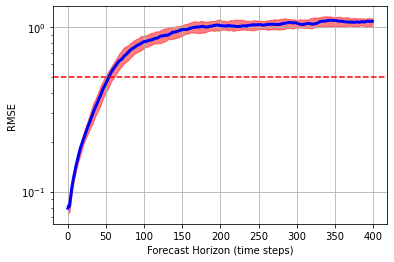

It takes around t = 0.54 for mean error to exceed 0.5


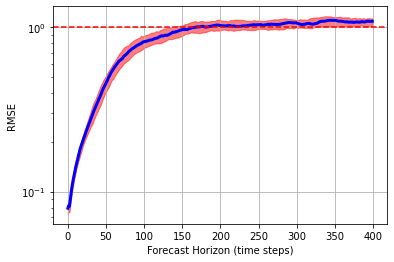

It takes around t = 1.69 for mean error to exceed 1.0


In [33]:
res_ensemble.plot_rmse(error_thresh = 0.5)
res_ensemble.plot_rmse(error_thresh = 1.)

In [34]:
res_ensemble.get_loss([0.2, 0.5, 1, 2, 3])

Median NRMSE at t = 0.2: 0.206
Median NRMSE at t = 0.5: 0.456
Median NRMSE at t = 1: 0.814
Median NRMSE at t = 2: 1.020
Median NRMSE at t = 3: 1.058


## 5.2 Variance

**Visualise for one dataset**

In [35]:
idx = 0

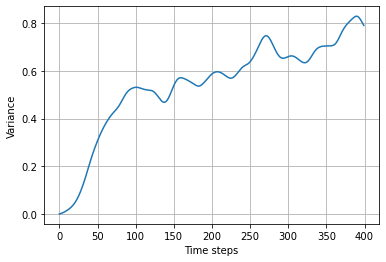

In [36]:
plt.plot(mu_preds.var(axis = 0)[idx].mean(axis = 1))
plt.grid("on")
plt.xlabel("Time steps")
plt.ylabel("Variance")
plt.show()

## 5.3 Negative Log LH

In [37]:
def neg_log_LH(mean_pred, sd_pred):
    d = 40
    
    constant_loss = d * np.log(2 * np.pi)
    mu_loss = (mean_pred - y_test)**2
    
    return 0.5 * (constant_loss + d * np.log(sd_pred) + (mu_loss / sd_pred**2)).mean(axis = (0, 2))

In [38]:
std_dev = mu_preds.std(axis = 0)

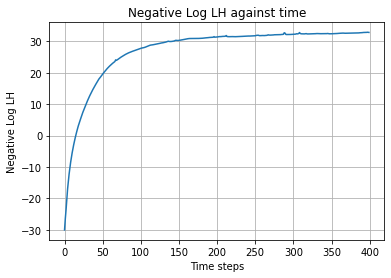

In [39]:
plt.plot(neg_log_LH(mixture_pred_all_mean,  std_dev))
plt.title("Negative Log LH against time")
plt.xlabel("Time steps")
plt.ylabel("Negative Log LH")
plt.grid("on")
plt.show()

In [40]:
print(f"Overall negative log LH: {neg_log_LH(mixture_pred_all_mean, std_dev).mean():.5f}")

Overall negative log LH: 27.20171
